# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
!pip install numpy

In [ ]:
import numpy
numpy.version.version

'1.21.6'

In [ ]:
!pip install -U torch torchvision

In [ ]:
!pip install torch==1.12.1

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

5.3.0


In [ ]:
import random
import os
import time

In [ ]:
def set_seed(seed):
    '''Делает наши результаты воспроизводимыми'''
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(22)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls /content/gdrive/

MyDrive


In [ ]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov  3 18:52 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls -1

characters_illustration.png
gdrive
label_encoder.pkl
sample_data
sample_submission.csv
testset
train


In [ ]:
!ls train

simpsons_dataset


In [ ]:
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Nov 11 16:19:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
          transform = transforms.Compose([
              transforms.Resize(size=(299, 299)),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.RandomRotation(degrees = 45),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
          ])
        else:
          transform = transforms.Compose([
             transforms.Resize(size=(299, 299)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


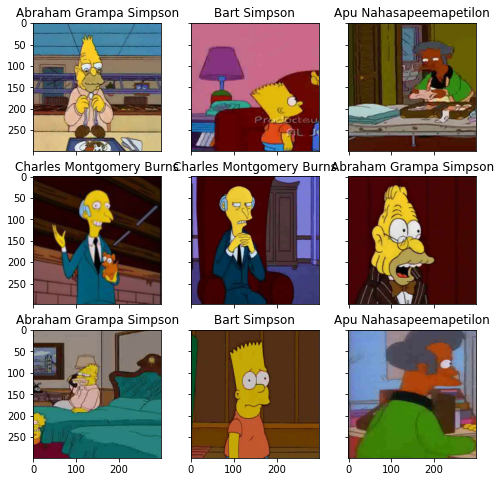

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    print(type(im_val))
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn5 = nn.BatchNorm2d(96)
        self.fc1 = nn.Linear(96*5*5, 1600)
        self.bn6 = nn.BatchNorm1d(1600)
        self.fc2 = nn.Linear(1600, 800)
        self.out = nn.Linear(800, n_classes)



    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        x = self.bn4(self.conv4(x))
        x = self.bn5(self.conv5(x))

        x = x.view(x.size(0), -1)
        x = self.bn6(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    print(train_loader)

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
import copy

In [ ]:

def train(train_dataset_, val_dataset_, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset_, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_, batch_size=batch_size, shuffle=False)
    best_wgt = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.parameters())
        opt = torch.optim.AdamW(model.parameters(), weight_decay = 0.1, lr = 1e-3)
        lr_sched = torch.optim.lr_scheduler.StepLR(opt, step_size = 2, gamma = 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            lr_sched.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
              best_acc = val_acc
              best_wgt = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            model_weights = copy.deepcopy(best_wgt)
            torch.save(model_weights, './model_best_weights.pth')

    model.load_state_dict(best_wgt)
    print("best_acc:", best_acc)
    return model, history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    print("We are here")
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

## Выполним OverSampling: для персонажей, чьих картинок меньше 100 в тестовом датасете, увеличим их число до 100

In [ ]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [ ]:
def create_dct_path_labels(train_files, train_labels):
  dct_simpsons = {}
  for label_i in np.unique(train_labels).tolist():
    dct_simpsons[label_i] = []

  for path_i, label_i in zip(train_files, train_labels):
    dct_simpsons[label_i].append(path_i)
  return dct_simpsons


In [ ]:
def print_dct(dct_simpsons):
  for key in dct_simpsons:
    print(f'{key}\t{dct_simpsons[key]}')

In [ ]:
dct_path_train = create_dct_path_labels(train_files, train_labels)


In [ ]:
print_dct(dct_path_train)

In [ ]:
for person in dct_path_train:
  if len(dct_path_train[person]) < 100:
    dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
    dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])


In [ ]:
for person in dct_path_train:
  print(f'{person}\t{len(dct_path_train[person])}')

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [ ]:
new_train_files = []

for person in dct_path_train:
  new_train_files.extend(dct_path_train[person])

new_train_labels = [path.parent.name for path in new_train_files]

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode = 'val')
train_dataset = SimpsonsDataset(new_train_files, mode = 'train') # Набор данных после применения OverSampling'a

## Попробуем различные архитектуры. Для VGG16, VGG19 и AlexNet заменим классификатор и заморозим несколько первых слоёв, остальные слои будем дообучать. Для Inception_v3 и EfficientNet-b4 заменим классификаторы и будем обучать всю сеть

## AlexNet Finetune

In [ ]:
from torchvision import models

In [ ]:

model = models.alexnet(pretrained = True)

In [ ]:
num_features = 9216
model.classifier = nn.Linear(num_features, n_classes)
if torch.cuda.is_available():
  model = model.to(DEVICE)


## VGG16_bn дообучение

In [ ]:
model = models.vgg16_bn(pretrained = True)

layers_to_unfreeze = 11

for param in model.features[:-layers_to_unfreeze].parameters():
  param.requires_grad = False

num_features = 25088
model.classifier = nn.Linear(num_features, n_classes)

if torch.cuda.is_available():
  model_extractor = model.to(DEVICE)

## VGG19_bn дообучение

In [ ]:
model = models.vgg19_bn(pretrained = True)
layers_to_unfreeze = 11

for param in model.features[:-layers_to_unfreeze].parameters():
  param.requires_grad = False

num_features = 25088
model.classifier = nn.Linear(num_features, n_classes)

if torch.cuda.is_available():
  model = model.to(DEVICE)


## Inception_v3 дообучение


In [ ]:
model = models.inception_v3(weights = True)
model.AuxLogits.fc = nn.Linear(768, n_classes)
model.fc = nn.Linear(2048, n_classes)
layers_to_unfreeze = 8

#for param in model.features[:-layers_to_unfreeze].parameters():
#  param.requires_grad = False

num_features = 25088
model.classifier = nn.Linear(num_features, n_classes)


model.aux_logits = False

## EfficientNet дообучение

In [ ]:
!pip install --upgrade efficientnet-pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

dim_features = model._fc.in_features
model._fc = nn.Linear(dim_features, n_classes)
if torch.cuda.is_available():
  model = model.to(DEVICE)

Loaded pretrained weights for efficientnet-b4


In [ ]:
model, history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=32)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 0.6807762917535797


epoch:  10%|█         | 1/10 [12:56<1:56:31, 776.89s/it]


Epoch 001 train_loss: 0.6808     val_loss 0.2194 train_acc 0.8309 val_acc 0.9425
loss 0.2225400089463492


epoch:  20%|██        | 2/10 [25:27<1:41:32, 761.61s/it]


Epoch 002 train_loss: 0.2225     val_loss 0.1650 train_acc 0.9422 val_acc 0.9589
loss 0.12230313317759277


epoch:  30%|███       | 3/10 [37:59<1:28:18, 756.99s/it]


Epoch 003 train_loss: 0.1223     val_loss 0.1970 train_acc 0.9676 val_acc 0.9530
loss 0.05403688371820377


epoch:  40%|████      | 4/10 [50:30<1:15:27, 754.65s/it]


Epoch 004 train_loss: 0.0540     val_loss 0.0850 train_acc 0.9863 val_acc 0.9824
loss 0.03908349226897825


epoch:  50%|█████     | 5/10 [1:03:04<1:02:52, 754.46s/it]


Epoch 005 train_loss: 0.0391     val_loss 0.1067 train_acc 0.9902 val_acc 0.9763
loss 0.022620752931826894


epoch:  60%|██████    | 6/10 [1:15:41<50:21, 755.36s/it]


Epoch 006 train_loss: 0.0226     val_loss 0.0918 train_acc 0.9944 val_acc 0.9813
loss 0.016323089955256633


epoch:  70%|███████   | 7/10 [1:28:18<37:47, 755.84s/it]


Epoch 007 train_loss: 0.0163     val_loss 0.1015 train_acc 0.9961 val_acc 0.9805
loss 0.008505729444897366


epoch:  80%|████████  | 8/10 [1:40:54<25:12, 756.07s/it]


Epoch 008 train_loss: 0.0085     val_loss 0.0906 train_acc 0.9978 val_acc 0.9834
loss 0.007113367394561686


epoch:  90%|█████████ | 9/10 [1:53:32<12:36, 756.59s/it]


Epoch 009 train_loss: 0.0071     val_loss 0.1060 train_acc 0.9981 val_acc 0.9790
loss 0.004209366537371199


epoch: 100%|██████████| 10/10 [2:06:09<00:00, 756.78s/it]


Epoch 010 train_loss: 0.0042     val_loss 0.1003 train_acc 0.9988 val_acc 0.9811


epoch: 100%|██████████| 10/10 [2:06:10<00:00, 757.02s/it]

best_acc: tensor(0.9834, device='cuda:0', dtype=torch.float64)


## Наилучший результат показала сеть EfficientNet-b4. Сделаем с ней предсказания

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

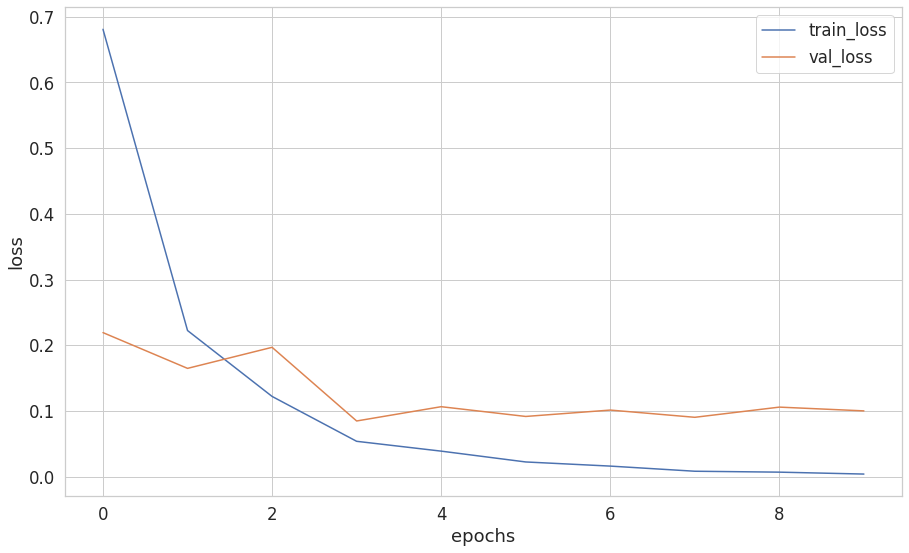

In [ ]:
import seaborn as sns

sns.set(style = 'whitegrid', font_scale=1.5)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)


actual_labels = [val_dataset[id][1] for id in idxs]


preds_class = [label_encoder.classes_[i] for i in y_pred]


Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average = 'micro')


In [ ]:
idxss = range(len(val_dataset))
imgss = [val_dataset[id][0].unsqueeze(0) for id in idxss]
probs_imgss = predict(model, imgss)

y_pred = np.argmax(probs_imgss, -1)
actual_labels = [val_dataset[id][1] for id in idxss]
pred_class = [pickle.load(open('label_encoder.pkl', 'rb')).classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average = 'macro')

0.9503067345211442

In [ ]:
f1_score(actual_labels, y_pred, average = 'weighted')

0.9808752584129804

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

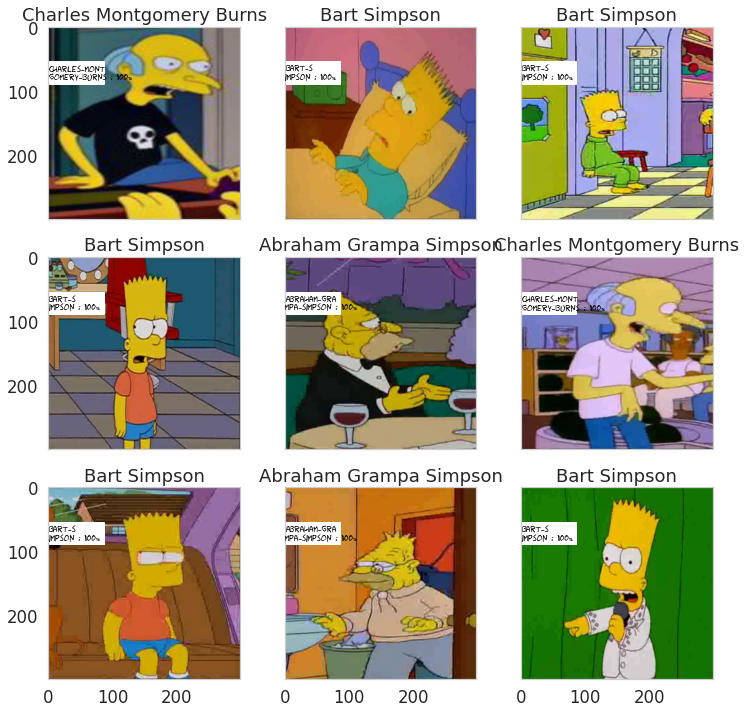

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
   # print('im_val:', im_val.size(), 'unsqueeze:', im_val.unsqueeze(0).size())
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
preds

In [ ]:
test_filenames

In [ ]:
! ls

characters_illustration.png  model_best_weights.pth  testset
gdrive			     sample_data	     train
label_encoder.pkl	     sample_submission.csv


In [ ]:
import pandas as pd


In [ ]:
pd.Series(test_filenames)

0        img0.jpg
1        img1.jpg
2       img10.jpg
3      img100.jpg
4      img101.jpg
          ...    
986    img987.jpg
987    img988.jpg
988    img989.jpg
989     img99.jpg
990    img990.jpg
Length: 991, dtype: object

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)
my_submit = pd.concat([pd.Series((test_filenames)), pd.Series(preds)], axis = 1, ignore_index = True)

In [ ]:
my_submit.rename(columns = {0: 'Id', 1: 'Expected'}, inplace = True)

In [ ]:
my_submit

In [ ]:
my_submit.to_csv('gdrive/MyDrive/simpsons/efficientnet-b4_finetune.csv', index=False) #Score: 0.99574

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
